In [26]:
import numpy as np
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
import os
import cv2
import matplotlib.pyplot as plt
from os import listdir
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_segmentation_masks
import matplotlib.patches as patches

In [38]:
path_train = "/kaggle/input/fadml-dataset-1/dataset_fadml_project/train"
path_val = "/kaggle/input/fadml-dataset-1/dataset_fadml_project/val"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


class breast_dataset(torch.utils.data.Dataset):

    def __init__(self,path,transforms=None):
        self.path = path
        self.transfrom = transforms
        self.img_name = []
        self.mask_name = []
        for img in listdir(self.path):
            if img[-8:] == "mask.png" :
                self.mask_name.append(img)
            elif img[-5:] == ").png":
                self.img_name.append(img)
    def __getitem__(self,idx):
#         print(self.path)
        img_path = os.path.join(self.path,self.img_name[idx])
        mask_path = os.path.join(self.path,self.mask_name[idx])
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2RGB).astype(np.float32)
        img_nor = img_gray /255
        img_res = torch.as_tensor(img_nor).to(device).permute(2,0,1)
        mask = cv2.imread(mask_path)
        mask_gray = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
        a,mask_01 = cv2.threshold(mask_gray,127,255,cv2.THRESH_BINARY)
        contours,hierarchy = cv2.findContours(mask_01,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        x,y,w,h = cv2.boundingRect((contours[0]))
        mask_ = mask_01.reshape(1,mask_01.shape[0],mask_01.shape[1])
        
        
        labels = [1]
        boxes = [x,y,x+w,y+h]
        target = {}
        target["masks"] = torch.as_tensor(mask_/255,dtype=torch.int64).to(device)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64).to(device)
        target["boxes"] = torch.as_tensor([boxes]).to(device)
        return img_res,target

    def __len__(self):
        return len(self.img_name)

In [3]:
def model_mask_rcnn(num_class):
    model = maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_class)
    return model


def collate_fn(batch):
    return tuple(zip(*batch))

In [39]:
breast_train = breast_dataset(path_train)
data_load_train = torch.utils.data.DataLoader(
    breast_train, batch_size=5, shuffle=True,num_workers=0, collate_fn=collate_fn)
breast_val = breast_dataset(path_val)
data_load_val = torch.utils.data.DataLoader(
    breast_val, batch_size=5, shuffle=True,num_workers=0, collate_fn=collate_fn)

num = 2
model = model_mask_rcnn(num)
model.to(device)
num_epoch = 150
param = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.SGD(param, lr=0.001,momentum = 0.9)
lr_scheduler = None

loss_hist=[]
val_hist = []
best_loss = float('inf')
for epoch in range(num_epoch):
    loss_num = 0
    loss_num_val = 0
    model.train()
    for img, targets in data_load_train:
        loss_dic = model(img, targets)
        loss = sum(loss for loss in loss_dic.values())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_num += loss  
    else:
        with torch.no_grad():  
            for img_val,targets_val in data_load_val:  
                loss_dic_val = model(img_val, targets_val)
                loss_val = sum(loss for loss in loss_dic_val.values())
                loss_num_val += loss_val
                  
    loss_hist.append(loss_num)
    val_hist.append(loss_num_val)
    if loss_num_val < best_loss:
        best_loss = loss_num_val
        torch.save(model.state_dict(), "/kaggle/working/model_best_dict.pt")
        torch.save(model, "/kaggle/working/model_best.pt")
    if lr_scheduler is not None:
        lr_scheduler.step()
    print("epoch:{},training loss:{}, validation loss {}".format(epoch, loss_num, loss_num_val))


epoch:0,training loss:50.60261154174805, validation loss 37.893123626708984
epoch:1,training loss:38.7962760925293, validation loss 36.0424690246582
epoch:2,training loss:36.198158264160156, validation loss 35.114044189453125
epoch:3,training loss:35.53462600708008, validation loss 32.683380126953125
epoch:4,training loss:32.87065505981445, validation loss 31.592052459716797
epoch:5,training loss:31.375106811523438, validation loss 29.74866485595703
epoch:6,training loss:30.358301162719727, validation loss 30.18351936340332
epoch:7,training loss:30.524192810058594, validation loss 28.900671005249023
epoch:8,training loss:29.802820205688477, validation loss 29.716781616210938
epoch:9,training loss:30.581579208374023, validation loss 28.53303337097168
epoch:10,training loss:28.956104278564453, validation loss 28.086244583129883
epoch:11,training loss:27.817276000976562, validation loss 27.168760299682617
epoch:12,training loss:26.746992111206055, validation loss 26.898834228515625
epoch:

In [5]:
# torch.save(model, '/kaggle/working/model_1.pt')

In [40]:
model = model_mask_rcnn(num)
model = torch.load('/kaggle/working/model_best.pt')

In [96]:
def apply_nms(orig_prediction, iou_thresh=None):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')


def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.title("Predicted Bounding Box on Original Image")
    plt.show()

In [95]:
cpu_device = torch.device("cpu")
model= model.eval()
# model = model_1.eval()
test_path = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (67).png'
mask_path="../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (67)_mask.png"
img_1 = cv2.imread(test_path)
img_2 = torch.as_tensor([img_1/255],dtype=torch.float32).permute(0,3,1,2).cuda()
outputs = model(img_2)

mask = outputs[0]["masks"][0] > 0.5
img_1 = cv2.imread(test_path)
img_1 = cv2.cvtColor(img_1,cv2.COLOR_BGR2RGB)
img_2 = torch.as_tensor(img_1).permute(2,0,1)
mask_out = draw_segmentation_masks(img_2,masks=mask,alpha=0.9)
out = np.array(mask_out.permute(1,2,0))
# plt.subplot(1,4,1)
# plt.imshow(out)
# plt.subplot(1,4,2)
# plt.imshow(np.array(mask.detach().permute(1,2,0).to(torch.device("cpu"))).squeeze())
# plt.subplot(1,4,3)
# plt.imshow(cv2.imread(mask_path))
# plt.subplot(1,4,4)
# plt.imshow(img_1)
# plt.show()

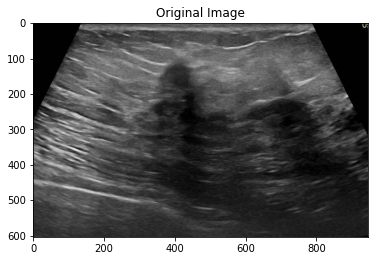

In [138]:
plt.imshow(img_1)
plt.title("Original Image")
plt.show()

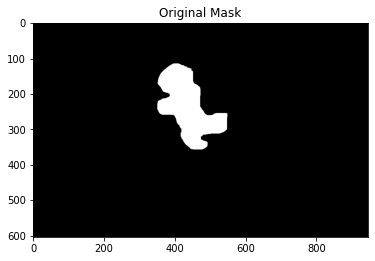

In [139]:
plt.imshow(cv2.imread(mask_path))
plt.title("Original Mask")
plt.show()

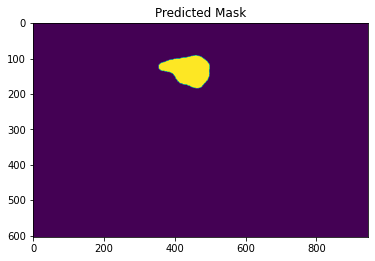

In [140]:
plt.imshow(np.array(mask.detach().permute(1,2,0).to(torch.device("cpu"))).squeeze())
plt.title("Predicted Mask")
plt.show()

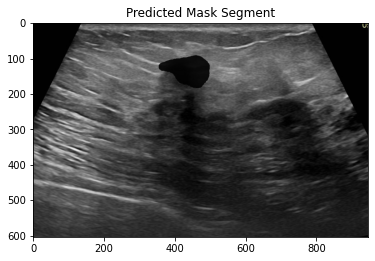

In [141]:
plt.imshow(out)
plt.title("Predicted Mask Segment")
plt.show()

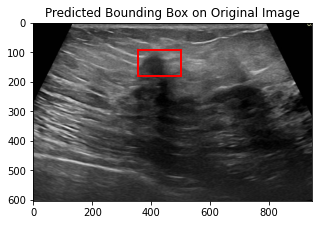

In [142]:
from torchvision import transforms as torchtrans
nms_prediction = apply_nms(outputs[0], iou_thresh=0.1)
plot_img_bbox(torch_to_pil(img_2), nms_prediction)


In [145]:
# IoU calculation
act_mask = cv2.imread(mask_path)
pred_mask = np.array(mask.detach().permute(1,2,0).to(torch.device("cpu"))).squeeze()
pred_mask = pred_mask.astype(np.int32)

# intersection = np.logical_and(np.array(mask.detach().permute(1,2,0).to(torch.device("cpu"))).squeeze(), m[:,:,0])
# union = np.logical_or(np.array(mask.detach().permute(1,2,0).to(torch.device("cpu"))).squeeze(), m[:,:,0])
intersection = np.logical_and(pred_mask, act_mask[:,:,2])
union = np.logical_or(pred_mask, act_mask[:,:,2])
iou_score = np.sum(intersection) / np.sum(union)
print('IoU is %s' % iou_score)

IoU is 0.1119906087539829


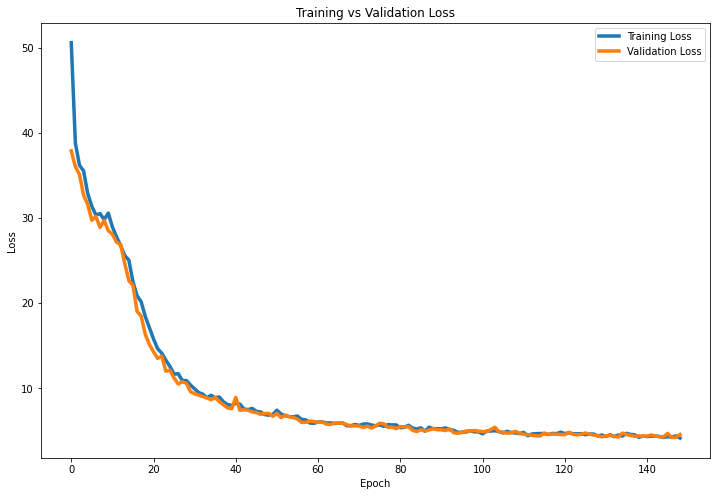

In [146]:
train_loss = []
val_loss = []
for i in range(epoch):
    train_loss.append(loss_hist[i].cpu().detach().numpy())
    val_loss.append(val_hist[i].cpu().detach().numpy())
train_loss = np.asarray(train_loss)
val_loss = np.asarray(val_loss)

plt.figure(figsize=(12,8))
plt.plot(train_loss, label="Training Loss", linewidth=3.5)
plt.plot(val_loss, label = "Validation Loss",  linewidth=3.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()